Starting point for MNIST digit classification according to Jalalvand

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from tqdm import tqdm

from sklearn.pipeline import FeatureUnion
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.base import clone
from sklearn.metrics import silhouette_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from joblib import dump, load, Parallel, delayed

from pyrcn.echo_state_network import ESNClassifier
from pyrcn.linear_model import IncrementalRegression, FastIncrementalRegression
from pyrcn.base import InputToNode, NodeToNode

from matplotlib import pyplot as plt
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
%matplotlib inline

Load the dataset

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

Provide standard split in training and test. Further split training set for validation. Normalize to a range between [0, 1].

Reshape to obtain 28x28 images

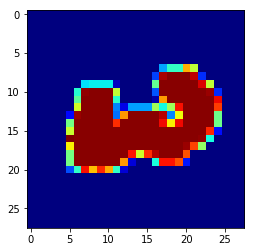

In [3]:
X_train, X_test = X[:60000] / 255., X[60000:] / 255.
y = y.astype(int)
y_train, y_test = y[:60000], y[60000:]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

X_train = [X_train[k].reshape(28, 28).T for k in range(len(X_train))]
X_val = [X_val[k].reshape(28, 28).T for k in range(len(X_val))]
X_test = [X_test[k].reshape(28, 28).T for k in range(len(X_test))]
plt.figure()
plt.imshow(X_train[1])

In [6]:
X_train_bin = [X_train[k]]

0.09993497398959583

Provide a basic ESN with Aza's parameters

In [9]:
base_input_to_nodes = InputToNode(hidden_layer_size=16000, activation='identity', k_in=10, input_scaling=0.4, bias_scaling=0.0)
base_nodes_to_nodes = NodeToNode(hidden_layer_size=16000, spectral_radius=0.4, leakage=0.5, bias_scaling=0.3, k_rec=10)

esn = ESNClassifier(input_to_nodes=[('default', base_input_to_nodes)],
                    nodes_to_nodes=[('default', base_nodes_to_nodes)],
                    regressor=FastIncrementalRegression(alpha=1e-3), random_state=10)

Train this ESN

In [ ]:
try:
    esn = load("rand_esn_16000_uni_fast.joblib")
except FileNotFoundError:
    with tqdm(total=len(X_train)) as pbar:
        for X, y in zip(X_train, y_train):
            y = np.repeat(y, repeats=28, axis=0)
            y[np.argwhere(X.sum(axis=1)==0)] = 10
            esn.partial_fit(X=X, y=y, classes=np.arange(11), update_output_weights=False)
            pbar.update(1)       
    with tqdm(total=len(X_val)) as pbar:
        for X, y in zip(X_val[:-1], y_val[:-1]):
            y = np.repeat(y, repeats=28, axis=0)
            y[np.argwhere(X.sum(axis=1)==0)] = 10
            esn.partial_fit(X=X, y=y, update_output_weights=False)
            pbar.update(1)
        X = X_val[-1]
        y = np.repeat(y_val[-1], repeats=28, axis=0)
        y[np.argwhere(X.sum(axis=1)==0)] = 10
        esn.partial_fit(X=X, y=y, update_output_weights=True)
        pbar.update(1)

    dump(esn, "rand_esn_16000_uni_fast.joblib")

 57%|███████████████████████████████████████▊                              | 27327/48000 [21:27:56<17:02:36,  2.97s/it]

Compute final measurements

In [ ]:
Y_true_train = []
Y_pred_train = []
with tqdm(total=len(X_train)) as pbar:
    for X, y in zip(X_train, y_train):
        y_pred = esn.predict_proba(X=X)[np.argwhere(X.sum(axis=1)!=0), :-1]
        Y_true_train.append(y)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        pbar.update(1)

with tqdm(total=len(X_val)) as pbar:
    for X, y in zip(X_val, y_val):
        y_pred = esn.predict_proba(X=X)[np.argwhere(X.sum(axis=1)!=0), :-1]
        Y_true_train.append(y)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        pbar.update(1)

Y_true_test = []
Y_pred_test = []
with tqdm(total=len(X_test)) as pbar:
    for X, y in zip(X_test, y_test):
        y_pred = esn.predict_proba(X=X)[np.argwhere(X.sum(axis=1)!=0), :-1]
        Y_true_test.append(y)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        pbar.update(1)

Confusion matrices

In [ ]:
cm = confusion_matrix(Y_true_train, Y_pred_train)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification training report for estimator %s:\n%s\n"
  % (esn, classification_report(Y_true_train, Y_pred_train, digits=4)))
plt.show()

cm = confusion_matrix(Y_true_test, Y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification test report for estimator %s:\n%s\n"
  % (esn, classification_report(Y_true_test, Y_pred_test, digits=4)))
plt.show()

Provide a basic ESN with Aza's parameters and train this ESN

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=8000, n_init=20, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=2, random_state=2)
kmeans.fit(X=np.concatenate(X_train + X_val))
base_input_to_nodes = InputToNode(hidden_layer_size=8000, activation='identity', k_in=10, input_scaling=0.5, bias_scaling=0.0, random_state=10)
base_nodes_to_nodes = NodeToNode(hidden_layer_size=8000, spectral_radius=0.8, leakage=0.2, bias_scaling=0.1, k_rec=10, random_state=10)
base_reg = FastIncrementalRegression(alpha=1e-3)
w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
# w_in = np.pad(np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None]), ((0, 1600), (0, 0)), mode='constant', constant_values=0)
base_input_to_nodes.fit(X=X_train[0])
base_input_to_nodes._input_weights = w_in.T


esn = ESNClassifier(input_to_nodes=[('default', base_input_to_nodes)],
                    nodes_to_nodes=[('default', base_nodes_to_nodes)],
                    regressor=base_reg)
esn._input_to_node =FeatureUnion(transformer_list=[('default', base_input_to_nodes)], n_jobs=None, transformer_weights=None).fit(X_train[0])
esn._input_to_node.transformer_list[0][1]._input_weights = w_in.T

try:
    esn = load("kmeans_esn_8000_uni_fast.joblib")
except FileNotFoundError:
    with tqdm(total=len(X_train)) as pbar:
        for X, y in zip(X_train, y_train):
            y = np.repeat(y, repeats=28, axis=0)
            y[np.argwhere(X.sum(axis=1)==0)] = 10
            esn.partial_fit(X=X, y=y, classes=np.arange(11))
            pbar.update(1)       
    with tqdm(total=len(X_val)) as pbar:
        for X, y in zip(X_val[:-1], y_val[:-1]):
            y = np.repeat(y, repeats=28, axis=0)
            y[np.argwhere(X.sum(axis=1)==0)] = 10
            esn.partial_fit(X=X, y=y, classes=np.arange(11), update_output_weights=False)
            pbar.update(1)
        X = X_val[-1]
        y = np.repeat(y_val[-1], repeats=28, axis=0)
        y[np.argwhere(X.sum(axis=1)==0)] = 10
        esn.partial_fit(X=X, y=y, update_output_weights=True)
        pbar.update(1)
    dump(esn, "kmeans_esn_8000_uni_fast.joblib")

Compute final measurements

In [ ]:
Y_true_train = []
Y_pred_train = []
with tqdm(total=len(X_train)) as pbar:
    for X, y in zip(X_train, y_train):
        y_pred = esn.predict_proba(X=X)[np.argwhere(X.sum(axis=1)!=0), :-1]
        Y_true_train.append(y)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        pbar.update(1)

with tqdm(total=len(X_val)) as pbar:
    for X, y in zip(X_val, y_val):
        y_pred = esn.predict_proba(X=X)[np.argwhere(X.sum(axis=1)!=0), :-1]
        Y_true_train.append(y)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        pbar.update(1)

Y_true_test = []
Y_pred_test = []
with tqdm(total=len(X_test)) as pbar:
    for X, y in zip(X_test, y_test):
        y_pred = esn.predict_proba(X=X)[np.argwhere(X.sum(axis=1)!=0), :-1]
        Y_true_test.append(y)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        pbar.update(1)

Confusion matrices

In [ ]:
cm = confusion_matrix(Y_true_train, Y_pred_train)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification training report for estimator %s:\n%s\n"
  % (esn, classification_report(Y_true_train, Y_pred_train, digits=4)))
plt.show()

cm = confusion_matrix(Y_true_test, Y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification test report for estimator %s:\n%s\n"
  % (esn, classification_report(Y_true_test, Y_pred_test, digits=4)))
plt.show()